# Initial Setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip
import wandb
wandb.login()

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
from imutils import paths
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

tf.random.set_seed(666)
np.random.seed(666)

# Getting the Pet Dataset

In [0]:
train_ds1, validation_ds1 = tfds.load(
    'cats_vs_dogs',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True
)

In [0]:
IMG_SHAPE = 128
BS = 256
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

train_ds = (
    train_ds1
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

# Building the model

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE,3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = False

	embeddings = encoder(inputs, training=False)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector=tf.keras.models.Sequential([
		Dense(128, activation="relu", trainable=False),
		UnitNormLayer()
	])
	return projector

In [0]:
encoder = encoder_net()
projector = projector_net()

In [23]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
unit_norm_layer_2 (UnitNormL (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
projector.build((None,2048))
projector.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  262272    
_________________________________________________________________
unit_norm_layer_3 (UnitNormL multiple                  0         
Total params: 262,272
Trainable params: 0
Non-trainable params: 262,272
_________________________________________________________________


# Loading the saved weights

In [0]:
encoder.load_weights("/content/encoder_r_1590489813.9405909.h5")

In [0]:
projector.load_weights("/content/projector_z1590489813.9405909.h5")

# Running forward passes

In [0]:
# Using just a single betch for visualization
images,labels=next(iter(train_ds))

In [0]:
encoded_vector = encoder.predict(images)

In [0]:
projected_vector = projector.predict(encoded_vector)

# Visualizing the embeddings


In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [0]:
def plot_embeddings(emb,labels,tool=tsne):
  if tool==tsne:
    tl=TSNE()
  else:
    tl=PCA()
  embedding=tl.fit_transform(emb)
  fig = plt.figure(figsize = (10, 10))
  sns.scatterplot(embedding[:,0], embedding[:,1], hue=labels)
  plt.show()

  return fig


In [0]:

import os
os.environ['WANDB_DISABLE_CODE'] = 'True'

In [32]:
wandb.init(entity='authors',project='scl',id='Visualisations_for_Pets_dataset')

W&B Run: https://app.wandb.ai/authors/scl/runs/Visualisations_for_Pets_dataset

### Encoded Embeddings with t-SNE





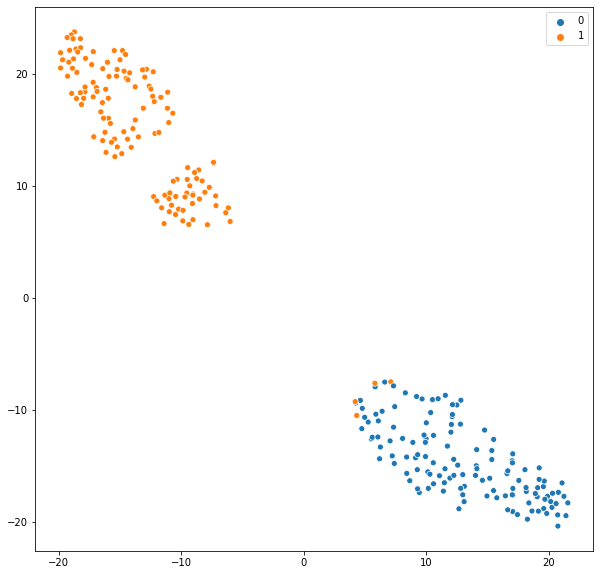

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [44]:
fig=plot_embeddings(encoded_vector,labels)
wandb.log(({"plotting encoder with t-SNE": fig}))

### Encoded Embeddings with PCA


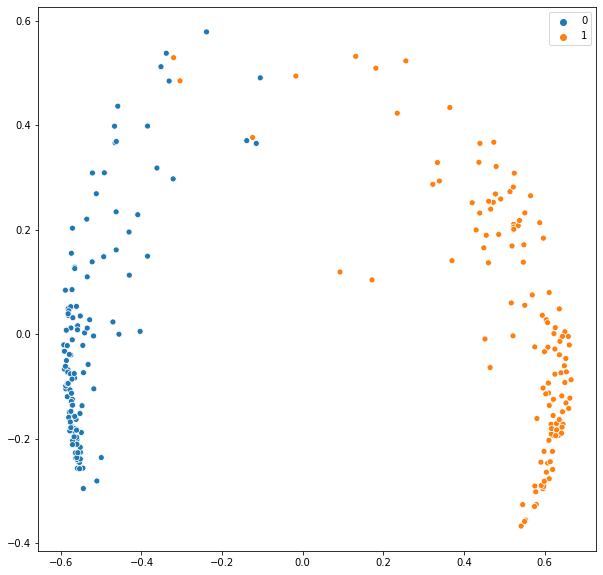

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [45]:
fig=plot_embeddings(encoded_vector,labels,pca)
wandb.log(({"plotting encoder with PCA ": fig}))

### Projected Embeddings with t-SNE


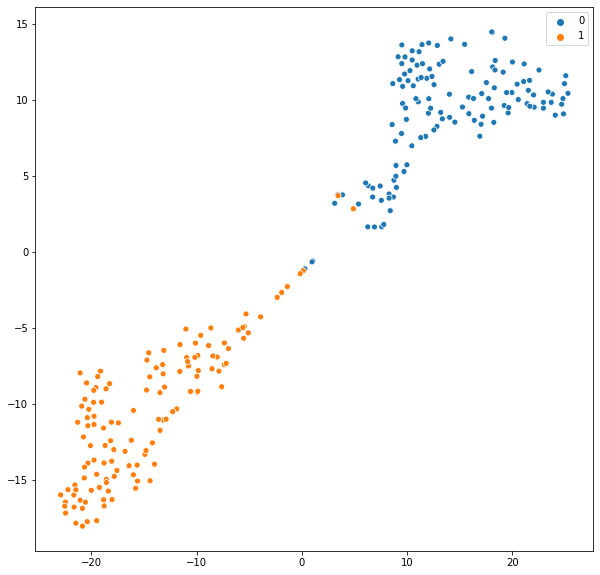

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [46]:
fig=plot_embeddings(projected_vector,labels)
wandb.log(({"plotting projected vector with t-SNE ": fig}))

### Projected Embeddings with PCA


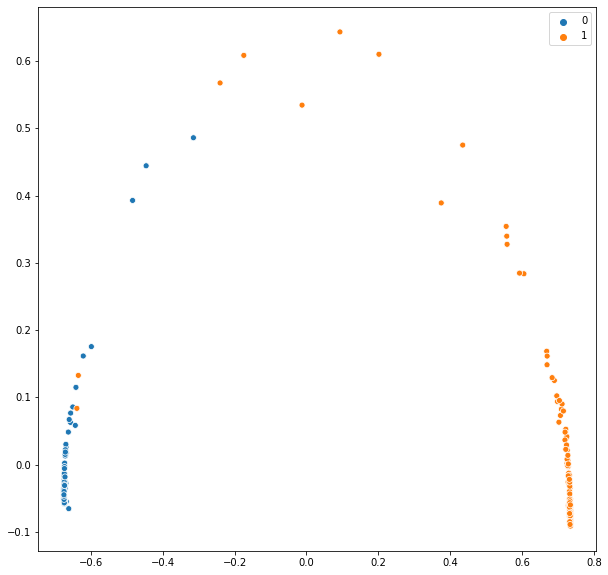

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [47]:
fig=plot_embeddings(projected_vector,labels,pca)
wandb.log(({"plotting projected vector with PCA ": fig}))